In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pydicom as dcm
import os
import nibabel as nib
from tqdm import tqdm
from tensorflow import keras
from keras import layers, models
import tensorflow_io as tfio
import cv2
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import tensorflow_addons as tfa
import glob
import scipy

In [6]:
def window_image(img, minn,maxx, intercept, slope, rescale=True):
    img = (img*slope +intercept) 
    
    img[img<minn] = minn 
    img[img>maxx] = maxx 
    if rescale: 
        img = (img - minn) / (maxx - minn)
    return img
    
def get_first_of_dicom_field_as_int(x):
    if type(x) == dcm.multival.MultiValue: return int(x[0])
    else: return int(x)
    
def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value,
                    data[('0028','1051')].value,
                    data[('0028','1052')].value,
                    data[('0028','1053')].value]
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

In [7]:
def channeling(img1, img2, img3):
    return np.stack([img1, img2, img3], axis=-1)

In [8]:
def load_image(path):
    data_path = '../../Downloads/rsna-2022-cervical-spine-fracture-detection/train_images/'
    UID = path.split('/')[-1][:-7]+"/"
    data = dcm.dcmread(data_path+UID+os.listdir(data_path+UID)[0])
    _, _, intercept, slope = get_windowing(data)
    img = nib.load(path)
    img = img.get_fdata()
    return img, intercept, slope

In [5]:
# def extract(path):
   
#     final_ct = load_image(path+"/"+"1.dcm").reshape(1,size,size)
#     for image in range(1, len(os.listdir(path))):
#         img = load_image(path+"/"+str(image)+".dcm").reshape(1,size,size)
#         final_ct = np.append(final_ct, img, axis=0)
        
#     resized_final_ct = cv2.resize(final_ct[:,:,0], (size,size)).reshape(1,size,size)
#     for i in range(1,final_ct.shape[1]):
#         resized_final_ct = np.append(resized_final_ct, cv2.resize(final_ct[:,:,i], (size,size)).reshape(1,size,size), axis=0)
  

#     return window(resized_final_ct)

In [9]:
bb_df = pd.read_csv("../../Downloads/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv")
df = pd.read_csv("../../Downloads/rsna-2022-cervical-spine-fracture-detection/train.csv")


In [10]:
bb_df[['x', 'y', 'width', 'height']] = (bb_df[['x', 'y', 'width', 'height']]//2).astype(int)

In [13]:
not_patients = df[df['patient_overall']==0]['StudyInstanceUID'].values

In [15]:
len(not_patients)

1058

In [75]:
def get_slice_list(uid):
   final_list = set({})
   for i in range(bb_df[bb_df['StudyInstanceUID'] == uid].shape[0]):
      minn = bb_df[bb_df['StudyInstanceUID'] == uid].iloc[i]["x"]
      width = bb_df[bb_df['StudyInstanceUID'] == uid].iloc[i]["width"]
      slice_list = list(range(minn,minn+width+1))
      final_list.update(slice_list)
   margin = int(len(final_list)//10)
   final_list = list(final_list)
   return final_list[margin:-margin]

In [77]:
path = '../storage/'
for patient in tqdm(patients[111:]):
    try:
        slices = get_slice_list(patient)
        ct,intercept,slope = load_image(path+patient+'.nii.gz')
        ct = scipy.ndimage.zoom(ct, (256/ct.shape[0],1,1))
        for slice in slices:
            img1 = window_image(ct[:,:,slice],100,600,intercept,slope)
            img2 = window_image(ct[:,:,slice],600,1100,intercept,slope)
            img3 = window_image(ct[:,:,slice],1100,1600,intercept,slope)
            img = channeling(img1,img2,img3)
            ni_img = nib.Nifti1Image(img, affine=None)
            nib.save(ni_img, '../sagittal_positive_slices/'+patient+"."+str(slice) +".nii.gz")
    
    except:
        print(patient)
        continue

  1%|          | 1/124 [00:06<13:56,  6.80s/it]

1.2.826.0.1.3680043.24673


 15%|█▍        | 18/124 [01:54<11:34,  6.55s/it]

1.2.826.0.1.3680043.27016


100%|██████████| 124/124 [13:34<00:00,  6.57s/it]


In [17]:
path = '../storage/'
for patient in tqdm(not_patients):
    try:
        slices = list(range(78,178))
        slices = np.random.choice(slices, size=10, replace=False)
        ct,intercept,slope = load_image(path+patient+'.nii.gz')
        ct = scipy.ndimage.zoom(ct, (256/ct.shape[0],1,1), order=1)
        for slice in slices:
            img1 = window_image(ct[:,:,slice],100,600,intercept,slope)
            img2 = window_image(ct[:,:,slice],600,1100,intercept,slope)
            img3 = window_image(ct[:,:,slice],1100,1600,intercept,slope)
            img = channeling(img1,img2,img3)
            ni_img = nib.Nifti1Image(img, affine=None)
            nib.save(ni_img, '../sagittal_negative_slices/'+patient+"."+str(slice) +".nii.gz")
    except:
        print(patient)
        continue

 19%|█▉        | 201/1058 [07:51<35:06,  2.46s/it]

1.2.826.0.1.3680043.16206


100%|██████████| 1058/1058 [40:16<00:00,  2.28s/it]


In [29]:

positive_list = glob.glob('../sagittal_positive_slices/*')
negative_list = glob.glob('../sagittal_negative_slices/*')

pos_80 = int((len(positive_list)*7)//10)
neg_80 = int((len(negative_list)*7)//10)

train_positive_list = positive_list[:pos_80]
test_positive_list = positive_list[pos_80:]
train_negative_list = negative_list[:neg_80]
test_negative_list = negative_list[neg_80:]


train_positive_list.extend(train_negative_list[::2])
test_positive_list.extend(test_negative_list[::2])


final_train_list = np.random.choice(train_positive_list, size = len(train_positive_list), replace=False)
final_test_list = np.random.choice(test_positive_list, size = len(test_positive_list), replace=False)

In [30]:
def data_gen():
    for image in final_train_list:
        if image.split("_")[1] == "positive":
            uid = image.split('\\')[1]
            weired_len = 8 + len(uid.split('.')[-3])
            uid = uid[:-weired_len]
            pdf = df[df['StudyInstanceUID'] == uid]
            co = pdf['patient_overall'].values[0]
            c1 = pdf['C1'].values[0]
            c2 = pdf['C2'].values[0]
            c3 = pdf['C3'].values[0]
            c4 = pdf['C4'].values[0]
            c5 = pdf['C5'].values[0]
            c6 = pdf['C6'].values[0]
            c7 = pdf['C7'].values[0]
            img = nib.load(image)
            img = img.get_fdata()
            yield ({"input_1": cv2.resize(img, (256, 256))},
                  {'co': co, 
                                        'c1': c1,
                                        'c2': c2,
                                        'c3': c3,
                                        'c4': c4,
                                        'c5': c5,
                                        'c6': c6,
                                        'c7': c7,},
                      {'co': 2, 
                                    'c1': c1+1,
                                    'c2': c2+1,
                                    'c3': c3+1,
                                    'c4': c4+1,
                                    'c5': c5+1,
                                    'c6': c6+1,
                                    'c7': c7+1})
        else:
            img = nib.load(image)
            img = img.get_fdata()
            yield ({"input_1": cv2.resize(img, (256, 256))},
                {'co': 0, 
                                        'c1': 0,
                                        'c2': 0,
                                        'c3': 0,
                                        'c4': 0,
                                        'c5': 0,
                                        'c6': 0,
                                        'c7': 0,},
                      {'co': 1, 
                                    'c1': 1,
                                    'c2': 1,
                                    'c3': 1,
                                    'c4': 1,
                                    'c5': 1,
                                    'c6': 1,
                                    'c7': 1})

def test_gen():
    for image in final_test_list:
        if image.split("_")[1] == "positive":
            uid = image.split('\\')[1]
            weired_len = 8 + len(uid.split('.')[-3])
            uid = uid[:-weired_len]
            pdf = df[df['StudyInstanceUID'] == uid]
            co = pdf['patient_overall'].values[0]
            c1 = pdf['C1'].values[0]
            c2 = pdf['C2'].values[0]
            c3 = pdf['C3'].values[0]
            c4 = pdf['C4'].values[0]
            c5 = pdf['C5'].values[0]
            c6 = pdf['C6'].values[0]
            c7 = pdf['C7'].values[0]
            img = nib.load(image)
            img = img.get_fdata()
            yield ({"input_1": cv2.resize(img, (256, 256))},
                  {'co': co, 
                                        'c1': c1,
                                        'c2': c2,
                                        'c3': c3,
                                        'c4': c4,
                                        'c5': c5,
                                        'c6': c6,
                                        'c7': c7,},
                      {'co': 2, 
                                    'c1': c1+1,
                                    'c2': c2+1,
                                    'c3': c3+1,
                                    'c4': c4+1,
                                    'c5': c5+1,
                                    'c6': c6+1,
                                    'c7': c7+1})
        else:
            img = nib.load(image)
            img = img.get_fdata()
            yield ({"input_1": cv2.resize(img, (256, 256))},
                {'co': 0, 
                                        'c1': 0,
                                        'c2': 0,
                                        'c3': 0,
                                        'c4': 0,
                                        'c5': 0,
                                        'c6': 0,
                                        'c7': 0,},
                      {'co': 1, 
                                    'c1': 1,
                                    'c2': 1,
                                    'c3': 1,
                                    'c4': 1,
                                    'c5': 1,
                                    'c6': 1,
                                    'c7': 1})


In [31]:
dataset = tf.data.Dataset.from_generator(
     data_gen,
     ({"input_1":tf.float32}, 
     {'co':tf.int8,
     'c1':tf.int8,
     'c2':tf.int8,
     'c3':tf.int8,
     'c4':tf.int8,
     'c5':tf.int8,
     'c6':tf.int8,
     'c7':tf.int8},
     {'co':tf.int8,
     'c1':tf.int8,
     'c2':tf.int8,
     'c3':tf.int8,
     'c4':tf.int8,
     'c5':tf.int8,
     'c6':tf.int8,
     'c7':tf.int8}),
    ({"input_1":tf.TensorShape([256,256,3])}, 
     {"co": tf.TensorShape([]), 
     "c1": tf.TensorShape([]),
     "c2": tf.TensorShape([]),
     "c3": tf.TensorShape([]),
     "c4": tf.TensorShape([]),
     "c5": tf.TensorShape([]),
     "c6": tf.TensorShape([]),
     "c7": tf.TensorShape([])},
    {"co": tf.TensorShape([]), 
     "c1": tf.TensorShape([]),
     "c2": tf.TensorShape([]),
     "c3": tf.TensorShape([]),
     "c4": tf.TensorShape([]),
     "c5": tf.TensorShape([]),
     "c6": tf.TensorShape([]),
     "c7": tf.TensorShape([])})
)

testset = tf.data.Dataset.from_generator(
     test_gen,
     ({"input_1":tf.float32}, 
     {'co':tf.int8,
     'c1':tf.int8,
     'c2':tf.int8,
     'c3':tf.int8,
     'c4':tf.int8,
     'c5':tf.int8,
     'c6':tf.int8,
     'c7':tf.int8},
     {'co':tf.int8,
     'c1':tf.int8,
     'c2':tf.int8,
     'c3':tf.int8,
     'c4':tf.int8,
     'c5':tf.int8,
     'c6':tf.int8,
     'c7':tf.int8}),
    ({"input_1":tf.TensorShape([256,256,3])}, 
     {"co": tf.TensorShape([]), 
     "c1": tf.TensorShape([]),
     "c2": tf.TensorShape([]),
     "c3": tf.TensorShape([]),
     "c4": tf.TensorShape([]),
     "c5": tf.TensorShape([]),
     "c6": tf.TensorShape([]),
     "c7": tf.TensorShape([])},
    {"co": tf.TensorShape([]), 
     "c1": tf.TensorShape([]),
     "c2": tf.TensorShape([]),
     "c3": tf.TensorShape([]),
     "c4": tf.TensorShape([]),
     "c5": tf.TensorShape([]),
     "c6": tf.TensorShape([]),
     "c7": tf.TensorShape([])})
)

In [32]:
augment = tf.keras.Sequential([
  keras.layers.RandomRotation((-0.3,0.3)),
  keras.layers.GaussianNoise(0.1),
  keras.layers.RandomContrast(0.1, seed=2),
  keras.layers.RandomZoom(
    (-0.2, 0.2),
    (-0.2, 0.2),
    fill_mode='reflect',
    interpolation='bilinear',
    seed=3)
])

In [33]:
dataset = dataset.map(lambda x, y, z: (augment(x['input_1']), y, z), 
              num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(15)
dataset = dataset.prefetch(1)


testset = testset.batch(15)
testset = testset.prefetch(1)

In [56]:
base = tf.keras.applications.ResNetRS101(
    include_top=False,
    weights="imagenet",
    pooling='avg',
    input_shape=(256,256,3),
)

inputs = keras.Input((256, 256, 3), name = "input_1")
x = base(inputs)

x0 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2', name='x0_2')(x)
x0 = tf.keras.layers.Dropout(0.5, name='x0_3')(x0)
x0 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2', name='x0_4')(x0)
x0 = tf.keras.layers.Dropout(0.5, name='x0_5')(x0)

x1 = tf.keras.layers.Dropout(0.4)(x)
x1 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x1)
x1 = tf.keras.layers.Dropout(0.4)(x1)
x1 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(x1)
x1 = tf.keras.layers.Dropout(0.4)(x1)

x2 = tf.keras.layers.Dropout(0.4)(x)
x2 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x2)
x2 = tf.keras.layers.Dropout(0.4)(x2)
x2 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(x2)
x2 = tf.keras.layers.Dropout(0.4)(x2)

x3 = tf.keras.layers.Dropout(0.4)(x)
x3 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x3)
x3 = tf.keras.layers.Dropout(0.4)(x3)
x3 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(x3)
x3 = tf.keras.layers.Dropout(0.4)(x3)

x4 = tf.keras.layers.Dropout(0.4)(x)
x4 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x4)
x4 = tf.keras.layers.Dropout(0.4)(x4)
x4 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(x4)
x4 = tf.keras.layers.Dropout(0.4)(x4)

x5 = tf.keras.layers.Dropout(0.4)(x)
x5 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x5)
x5 = tf.keras.layers.Dropout(0.4)(x5)
x5 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(x5)
x5 = tf.keras.layers.Dropout(0.4)(x5)

x6 = tf.keras.layers.Dropout(0.4)(x)
x6 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x6)
x6 = tf.keras.layers.Dropout(0.4)(x6)
x6 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(x6)
x6 = tf.keras.layers.Dropout(0.4)(x6)

x7 = tf.keras.layers.Dropout(0.4)(x)
x7 = tf.keras.layers.Dense(128, activation='relu')(x7)
x7 = tf.keras.layers.Dropout(0.4)(x7)
x7 = tf.keras.layers.Dense(32, activation='relu')(x7)
x7 = tf.keras.layers.Dropout(0.4)(x7)

outputo = keras.layers.Dense(1 ,activation = 'sigmoid', name="co")(x0)
output1 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c1")(x1)
output2 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c2")(x2)
output3 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c3")(x3)
output4 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c4")(x4)
output5 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c5")(x5)
output6 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c6")(x6)
output7 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c7")(x7)
                                               
model = keras.models.Model(inputs=inputs, outputs=[outputo,output1,output2,output3,output4,output5,output6,output7])

In [57]:
def lr_schedule(epoch, lr):
    return lr/(epoch+1)

In [58]:
opt = tfa.optimizers.AdamW(
    weight_decay=2e-4,
    learning_rate = 0.001,
    beta_1 = 0.9,
    beta_2 = 0.999,
    epsilon = 1e-07,
    name = 'AdamW',
)
loss = tf.keras.losses.BinaryCrossentropy(
    label_smoothing=0.2, 
    reduction=tf.keras.losses.Reduction.AUTO,
    name='binary_crossentropy'
)
metrics = [tf.keras.metrics.AUC()]
model.compile(optimizer=opt,
              loss={"co": loss, 
                   "c1": loss,
                   "c2": loss,
                   "c3": loss,
                   "c4": loss,
                   "c5": loss,
                   "c6": loss,
                   "c7": loss,},
                metrics={"co": [tf.keras.metrics.AUC()],
                "c1": [tf.keras.metrics.AUC()], 
                "c2": [tf.keras.metrics.AUC()], 
                "c3": [tf.keras.metrics.AUC()], 
                "c4": [tf.keras.metrics.AUC()], 
                "c5": [tf.keras.metrics.AUC()], 
                "c6": [tf.keras.metrics.AUC()], 
                "c7": [tf.keras.metrics.AUC()]})

In [59]:
!mkdir best_weights_multiclass

A subdirectory or file best_weights_multiclass already exists.


In [60]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = './best_weights_multiclass/model',
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
)

In [61]:
# for layer in model.layers[:2]:
#     layer.trainable = True
# for i in range(1,6):
#     model.get_layer('x0_'+str(i)).trainable = False
# model.get_layer('co').trainable = False

In [62]:
history = model.fit(dataset, validation_data = testset, epochs=10, callbacks=[model_checkpoint, tf.keras.callbacks.LearningRateScheduler(lr_schedule)])

Epoch 1/10
      8/Unknown - 41s 377ms/step - loss: 25.8119 - co_loss: 1.1338 - c1_loss: 0.7514 - c2_loss: 0.6764 - c3_loss: 0.7621 - c4_loss: 0.7090 - c5_loss: 0.8093 - c6_loss: 0.8146 - c7_loss: 0.8595 - co_auc_28: 0.4734 - c1_auc_29: 0.5049 - c2_auc_30: 0.6403 - c3_auc_31: 0.5193 - c4_auc_32: 0.3827 - c5_auc_33: 0.3273 - c6_auc_34: 0.4597 - c7_auc_35: 0.4449

KeyboardInterrupt: 

In [54]:
model.load_weights('./best_weights/model')

ValueError: Received incompatible tensor with shape (1, 1, 1024, 512) when attempting to restore variable with shape (1, 1, 1024, 256) and name layer_with_weights-0/layer_with_weights-118/kernel/.ATTRIBUTES/VARIABLE_VALUE.

In [134]:
model.evaluate(testset)

466/466 [==============================] - 65s 139ms/step - loss: 4.8730 - co_loss: 0.6445 - c1_loss: 0.5760 - c2_loss: 0.5886 - c3_loss: 0.5247 - c4_loss: 0.5996 - c5_loss: 0.6300 - c6_loss: 0.6403 - c7_loss: 0.6092 - co_auc_28: 0.9557 - c1_auc_29: 0.7460 - c2_auc_30: 0.8097 - c3_auc_31: 0.8120 - c4_auc_32: 0.8698 - c5_auc_33: 0.8560 - c6_auc_34: 0.8380 - c7_auc_35: 0.8308


[4.873042583465576,
 0.6445224285125732,
 0.5760260820388794,
 0.5885512232780457,
 0.5246588587760925,
 0.5996190309524536,
 0.6300228834152222,
 0.6403295993804932,
 0.6092018485069275,
 0.9557389616966248,
 0.746047854423523,
 0.8096691370010376,
 0.8120142817497253,
 0.8697803020477295,
 0.8560285568237305,
 0.8379635214805603,
 0.8308084011077881]

In [110]:
positive_df = df[df['patient_overall']==0]

In [113]:
positive_df.iloc[0]

StudyInstanceUID    1.2.826.0.1.3680043.12351
patient_overall                             0
C1                                          0
C2                                          0
C3                                          0
C4                                          0
C5                                          0
C6                                          0
C7                                          0
Name: 3, dtype: object

In [27]:
not_bb_pos = []
for positive in positive_df['StudyInstanceUID']:
    if positive not in bb_df['StudyInstanceUID'].unique():
        not_bb_pos.append(positive)

In [114]:
# df[df['StudyInstanceUID'] == not_bb_pos[670]]
positive_df.iloc[10]

StudyInstanceUID    1.2.826.0.1.3680043.5565
patient_overall                            0
C1                                         0
C2                                         0
C3                                         0
C4                                         0
C5                                         0
C6                                         0
C7                                         0
Name: 28, dtype: object

In [115]:
def get_sample(patient):
    path = '../storage/'
    ct,intercept,slope = load_image(path+patient+'.nii.gz')
    ct = scipy.ndimage.zoom(ct, (256/ct.shape[0],1,1))
    ct = np.transpose(ct, axes=[2,0,1])
    
    img1 = window_image(ct,100,600,intercept,slope)
    img2 = window_image(ct,600,1100,intercept,slope)
    img3 = window_image(ct,1100,1600,intercept,slope)
    return channeling(img1,img2,img3)
        

In [120]:
positive_df.iloc[1000]

StudyInstanceUID    1.2.826.0.1.3680043.32577
patient_overall                             0
C1                                          0
C2                                          0
C3                                          0
C4                                          0
C5                                          0
C6                                          0
C7                                          0
Name: 1901, dtype: object

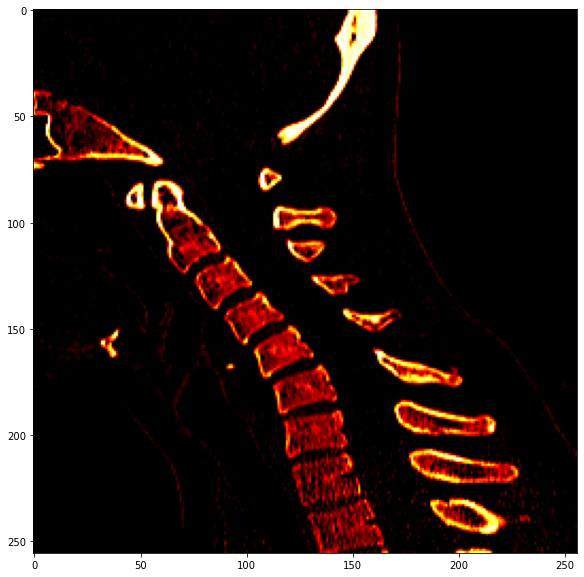

In [125]:
plt.figure(figsize=(10,10))
plt.imshow(get_sample(positive_df.iloc[1010]['StudyInstanceUID'])[122])

In [126]:
pred = model.predict(get_sample(positive_df.iloc[1010]['StudyInstanceUID'])[108:138])

1/1 [==============================] - 0s 56ms/step


In [127]:
pred[0]

array([[0.8477029 ],
       [0.8423462 ],
       [0.8466592 ],
       [0.7351049 ],
       [0.7064031 ],
       [0.68990654],
       [0.7127367 ],
       [0.7103538 ],
       [0.82996726],
       [0.84324497],
       [0.8126496 ],
       [0.8538195 ],
       [0.84531426],
       [0.86274254],
       [0.8461799 ],
       [0.8391824 ],
       [0.8452639 ],
       [0.8390644 ],
       [0.8519257 ],
       [0.7709528 ],
       [0.7796445 ],
       [0.8408633 ],
       [0.85472494],
       [0.80796355],
       [0.81194913],
       [0.8310048 ],
       [0.8277046 ],
       [0.84412134],
       [0.840939  ],
       [0.82650244]], dtype=float32)

In [23]:
!mkdir final_model

In [135]:
model.save("./final_model/model")

INFO:tensorflow:Assets written to: ./final_model/model\assets


INFO:tensorflow:Assets written to: ./final_model/model\assets


In [137]:
!mkdir feature_extractor


In [138]:
base.save('./feature_extractor/feature_extractor')

INFO:tensorflow:Assets written to: ./feature_extractor/feature_extractor\assets


INFO:tensorflow:Assets written to: ./feature_extractor/feature_extractor\assets


In [140]:
256*256*3

196608

In [141]:
a = np.arange(196608).reshape(1,256,256,3)

In [144]:
np.array(base(a)).mean()

1827.72